Configuracion y chequeo del entorno

Conectar con Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalacion de modulos y bibliotecas

In [27]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow probability " + tfp.__version__)
import os
import cv2
print("cv2 " + cv2.__version__)
import zipfile
print("zip file " + tf.__version__)
import numpy as np
print("numpy " + np.__version__)

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

Tensorflow version 2.15.0
Tensorflow probability 0.22.0
cv2 4.8.0
zip file 2.15.0
numpy 1.23.5


Armado de la red neuronal - convolucional

In [15]:
#preprocesamiento de las imagenes // se debe cambiar la carpeta!
trainpath_source = "/content/drive/MyDrive/public/CatsAndDogs.zip"
files_path = "/content"
trainpath = "/content/train"

In [16]:
with zipfile.ZipFile(trainpath_source, 'r') as zipp:
  zipp.extractall(files_path)

In [17]:
!ls /content/train | wc -l

25000


In [18]:
images = []
labels = []

for image in os.scandir(trainpath):
  img = cv2.imread(trainpath+"/"+image.name)           #leo las imagenes desde la carpeta
  img_mtx = cv2.resize(img, (180,180))            #transformo a mismo tamaño, classe narray
  images.append(list(img_mtx))
  if image.name.startswith("cat"):
    lebel = 0
  elif image.name.startswith("dog"):
    lebel = 1
  labels.append(lebel)

#images = tf.data.Dataset.from_tensor_slices(images)

In [21]:
X = np.array(images)
Y = np.array(labels)

In [22]:
#separo las imagenes en train y testeo
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=True)

In [23]:
#convertimos a one hot encoding
y_test_he = tf.one_hot(y_test,2)
y_train_he = tf.one_hot(y_train,2)

In [24]:
# eliminamos de memoria lo que ya no se va a usar
del images, labels, X, Y, y_train, y_test

In [25]:
#modificacion de las imagenes de forma aleatoria para generar mayor diversidad y evitar baias y armado de la estructura neuronal
model = tf.keras.Sequential([
                 keras.layers.RandomFlip('horizontal',input_shape=(180, 180, 3)), #rota imagen
                 keras.layers.RandomRotation(0.15),                               #rota imagen
                 keras.layers.RandomZoom(0.2),                                    #zoom imagen
                 keras.layers.RandomWidth(0.1),                                   #ensancha imagen
                 keras.layers.RandomHeight(0.1),                                  #alarga imagen
])
model.add(layers.Conv2D(32, (5,5), strides=(2,2), padding="same", activation="relu", input_shape=(180,180,3)))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(1,1)))
model.add(layers.Conv2D(48, (3,3), strides=(2,2), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(1,1)))
model.add(layers.Conv2D(64, (3,3), strides=(1,1)))
model.add(layers.GlobalMaxPooling2D())                                            #es como el flatten(), genera un vector
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))                                                    #para quitar overfitting
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2))                                                        #la salida tiene 2 neuronas porque me dice si es perro o gato

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_width (RandomWidth)  (None, 180, None, 3)      0         
                                                                 
 random_height (RandomHeigh  (None, None, None, 3)     0         
 t)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    2

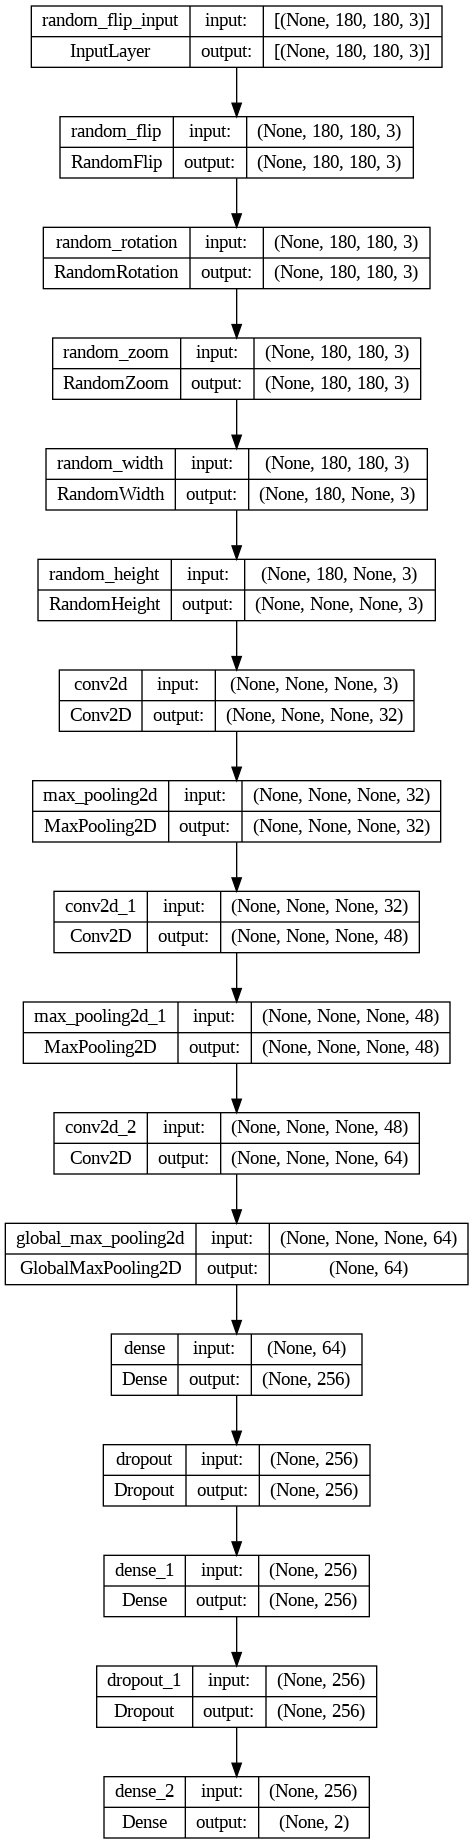

In [28]:
#para visualizar modelo de forma esquematica
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
#se define la funcion de perdida, de optimizacion y metricas
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #CategoricalCrossEntropy porque hay mas de una etiqueta y es categorica. Logits=TRUE porque no se uso la funcion de activacion softmax en la capa de salida
    metrics = ["accuracy"],
)

In [30]:
# se definen los callbacks: early stopper y reduce learning rate

early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
)

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.0001,
)

In [31]:
# se ajusta el modelo
history = model.fit(
    x_train, y_train_he,
    validation_data=(x_test, y_test_he),
    batch_size = 250,
    epochs = 30,
    callbacks = [early_stopping, learning_rate_reduction]
)

Epoch 1/30
80/80 [==============================] - 191s 2s/step - loss: 1.6390 - accuracy: 0.5359 - val_loss: 0.6529 - val_accuracy: 0.6128 - lr: 0.0010
Epoch 2/30
80/80 [==============================] - 134s 2s/step - loss: 0.6516 - accuracy: 0.6109 - val_loss: 0.6162 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 3/30
80/80 [==============================] - 109s 1s/step - loss: 0.6220 - accuracy: 0.6513 - val_loss: 0.6150 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 4/30
80/80 [==============================] - 89s 1s/step - loss: 0.6030 - accuracy: 0.6705 - val_loss: 0.5896 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 5/30
80/80 [==============================] - 75s 927ms/step - loss: 0.5837 - accuracy: 0.6920 - val_loss: 0.5729 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 6/30
80/80 [==============================] - 68s 849ms/step - loss: 0.5610 - accuracy: 0.7113 - val_loss: 0.5525 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 7/30
80/80 [==============================] - 52s 652ms/step - loss

<Axes: >

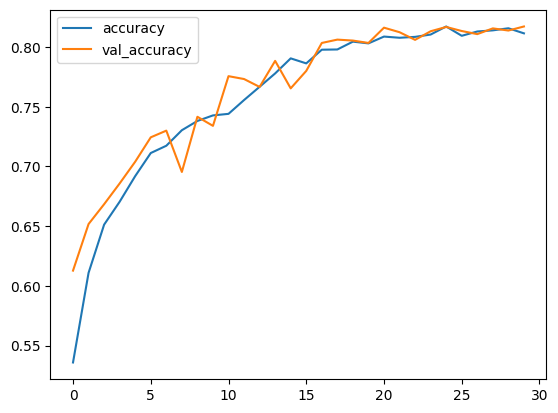

In [32]:
# se evalua el modelo
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df[["accuracy", "val_accuracy"]].plot()